# Chemioterapia — PDE reakcji–dyfuzji (S, R, I, C)
Porównanie solwerów: (A) eksplicytny, (B) pół-implicytny (operator-splitting).  
Metryki: czas obliczeń, stabilność, zbieżność względem rozdzielczości, integralna masa guza (∫(S+R) dx), minima/maksima C.

Zapisy:
- Wykresy do `./figs/`
- Dane/metryki do `./out/` (CSV, NPY)


In [19]:
import os, time, math, json, csv
from pathlib import Path
import numpy as np
import csv
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict

# Scipy do solwera pół-implicytnego
try:
    import scipy.sparse as sp
    import scipy.sparse.linalg as spla
    SCIPY_AVAILABLE = True
except Exception as e:
    SCIPY_AVAILABLE = False
    print("Uwaga: SciPy niedostępne — solver pół-implicytny będzie wyłączony:", e)

# Pillow do tworzenia GIF
try:
    from PIL import Image
    PIL_AVAILABLE = True
except Exception as e:
    PIL_AVAILABLE = False
    print("Uwaga: Pillow niedostępny — animacje GIF nie będą tworzone:", e)
    print("Aby zainstalować: pip install pillow")

# Katalogi na wyniki
Path("figs").mkdir(exist_ok=True)
Path("out").mkdir(exist_ok=True)

def savefig(path, dpi=160, bbox_inches="tight"):
    plt.savefig(path, dpi=dpi, bbox_inches=bbox_inches)
    print(f"[Zapisano wykres] {path}")

def save_array(path, arr):
    np.save(path, arr)
    print(f"[Zapisano macierz] {path}.npy")

def walltime():
    return time.perf_counter()

np.set_printoptions(precision=4, suppress=True)

### Parametry modelu (Params)

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

In [20]:
@dataclass
class Params:
    # Dyfuzje
    D_S: float = 0.0       # komórki zwykle dyfundują bardzo wolno; rozpoczniemy od 0
    D_R: float = 0.0
    D_I: float = 0.0
    D_C: float = 1.0e-2    # lek dyfunduje najszybciej

    # Wzrost i nośność
    rho_S: float = 0.04
    rho_R: float = 0.03
    K: float = 1.0

    # Cytotoksyczność
    alpha_S: float = 0.8
    alpha_R: float = 0.1

    # Immunologia
    gamma_S: float = 0.02
    gamma_R: float = 0.02
    sigma: float = 0.05
    delta: float = 0.1

    # Farmakokinetyka leku
    lam: float = 0.2
    beta: float = 0.0  # konsumpcja/wiązanie przez komórki; zaczniemy od 0 dla prostoty

    # Indukcja oporności (funkcja Hill)
    mu_max: float = 0.05
    C50: float = 0.2
    m_hill: int = 3

    # Dawkowanie
    dose_type: str = "bolus_periodic"  # 'bolus_periodic' | 'infusion_const' | 'none'
    dose_A: float = 1.0
    dose_period: float = 5.0
    infusion_rate: float = 0.0

def mu_of_C(C, mu_max, C50, m):
    # Stabilna postać: ratio = (C/C50)^m; mu = mu_max * ratio / (1+ratio)
    C_nonneg = np.maximum(C, 0.0)
    ratio = np.power(C_nonneg / (C50 + 1e-12), m)
    return mu_max * (ratio / (1.0 + ratio))

def dosing_term(x, y, t, p: Params):
    if p.dose_type == "none":
        return 0.0
    if p.dose_type == "infusion_const":
        return p.infusion_rate
    if p.dose_type == "bolus_periodic":
        # aproksymacja impulsu: krótka „kropla” trwająca 1% okresu
        tau = 0.01 * p.dose_period
        phase = t % p.dose_period
        return p.dose_A / tau if phase < tau else 0.0
    return 0.0

### Definicja siatki obliczeniowej (Grid) i parametrów domeny

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

In [21]:
@dataclass
class Grid:
    Nx: int
    Ny: int
    Lx: float = 1.0
    Ly: float = 1.0

    def __post_init__(self):
        self.dx = self.Lx / (self.Nx - 1)
        self.dy = self.Ly / (self.Ny - 1)
        self.x = np.linspace(0.0, self.Lx, self.Nx)
        self.y = np.linspace(0.0, self.Ly, self.Ny)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing="xy")

def laplacian_neumann(U, dx, dy):
    """
    5-punktowy Laplasjan z warunkiem Neumanna (pochodna normalna = 0).
    Realizacja: odbicie wartości na brzegu (ghost cell reflection).
    """
    Ux_f = np.pad(U, ((0,0),(1,1)), mode="edge")
    Uy_f = np.pad(U, ((1,1),(0,0)), mode="edge")
    Uc = U

    Uxx = (Ux_f[:,2:] - 2*Uc + Ux_f[:,:-2]) / (dx*dx)
    Uyy = (Uy_f[2:,:] - 2*Uc + Uy_f[:-2,:]) / (dy*dy)

    return Uxx + Uyy

### Kod pomocniczy / logika dodatkowa

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

In [22]:
def init_fields(grid: Grid):
    X, Y = grid.X, grid.Y
    # Początkowy guz: kopuła w centrum (S), trochę R na obrzeżu
    r = np.sqrt((X-0.5*grid.Lx)**2 + (Y-0.5*grid.Ly)**2)
    S0 = 0.5*np.exp(-(r/0.15)**2)
    R0 = 0.05*np.exp(-((r-0.2)/0.1)**2)

    # Początkowa aktywność immunologiczna niska, jednorodna
    I0 = 0.02*np.ones_like(S0)
    # Lek na starcie brak
    C0 = np.zeros_like(S0)

    return S0, R0, I0, C0

### Stabilna funkcja oporności μ(C)

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

In [23]:
def reaction_terms(S, R, I, C, p: Params):
    """Zwraca RHS reakcji: (fS, fR, fI, fC) bez części dyfuzyjnej i bez dopływu I_in."""
    N = S + R
    growth_S = p.rho_S * S * (1.0 - N / p.K)
    growth_R = p.rho_R * R * (1.0 - N / p.K)

    kill_S = p.alpha_S * C * S + p.gamma_S * I * S
    kill_R = p.alpha_R * C * R + p.gamma_R * I * R

    mu = mu_of_C(C, p.mu_max, p.C50, p.m_hill)

    dS = growth_S - kill_S - mu * S
    dR = growth_R - kill_R + mu * S

    dI = p.sigma * N - p.delta * I

    dC = - p.lam * C - p.beta * C * N

    return dS, dR, dI, dC

### Operator Laplasjana z warunkami Neumanna; funkcje dyfuzji

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

In [24]:
def step_explicit(S, R, I, C, grid: Grid, dt: float, p: Params):
    # Reakcje
    fS, fR, fI, fC = reaction_terms(S, R, I, C, p)

    # Dyfuzja
    if p.D_S != 0: diff_S = p.D_S * laplacian_neumann(S, grid.dx, grid.dy)
    else: diff_S = 0.0
    if p.D_R != 0: diff_R = p.D_R * laplacian_neumann(R, grid.dx, grid.dy)
    else: diff_R = 0.0
    if p.D_I != 0: diff_I = p.D_I * laplacian_neumann(I, grid.dx, grid.dy)
    else: diff_I = 0.0
    diff_C = p.D_C * laplacian_neumann(C, grid.dx, grid.dy)

    # Dawkowanie (tylko C), przestrzennie jednorodne dla prostoty
    # Można tu wstawić funkcję przestrzenną dla podania miejscowego.
    t_dummy = step_explicit.t  # czas z atrybutu funkcji (aktualizowany w run)
    I_in = dosing_term(grid.X, grid.Y, t_dummy, p)

    # Aktualizacja
    S_new = S + dt*(fS + diff_S)
    R_new = R + dt*(fR + diff_R)
    I_new = I + dt*(fI + diff_I)
    C_new = C + dt*(fC + diff_C + I_in)

    # Nieujemność
    S_new = np.clip(S_new, 0.0, None)
    R_new = np.clip(R_new, 0.0, None)
    I_new = np.clip(I_new, 0.0, None)
    C_new = np.clip(C_new, 0.0, None)
    return S_new, R_new, I_new, C_new

# atrybut do przekazywania czasu bez zmiany sygnatury
step_explicit.t = 0.0

def stability_dt_explicit(grid: Grid, p: Params, safety=0.24):
    # kryterium CFL dla dyfuzji (2D): dt <= safety * min(dx^2, dy^2) / (4*D_max)
    Dmax = max(p.D_S, p.D_R, p.D_I, p.D_C)
    if Dmax <= 0:
        return 1e-2  # tylko reakcje — mały krok domyślny
    return safety * min(grid.dx**2, grid.dy**2) / (4.0*Dmax + 1e-12)

### Operator Laplasjana z warunkami Neumanna; funkcje dyfuzji

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

In [25]:
# --- 1D Laplasjan z Neumannem (trójdiagonalny), skala 1/h^2 ---
def laplacian_1d_neumann(n, h):
    main = -2.0 * np.ones(n)
    off  =  1.0 * np.ones(n-1)
    # Neumann: na brzegach -1 zamiast -2 (pochodna normalna = 0)
    main[0]  = -1.0
    main[-1] = -1.0
    L = sp.diags([off, main, off], offsets=[-1, 0, 1], format="csr") / (h*h)
    return L

def build_diffusion_operators_2d_neumann(Nx, Ny, dx, dy, D, dt, theta):
    """
    2D Laplacjan: L = kron(Iy, Lx) + kron(Ly, Ix), Neumann w każdym kierunku.
    Operator dyfuzji: D * L. Schemat theta: (I - theta*dt*D*L) U^{n+1} = (I + (1-theta)*dt*D*L) U^*.
    Uwaga: zakładamy ravel(order="C") tj. indeks k = i + j*Nx (i: x, j: y).
    """
    Ix = sp.eye(Nx, format="csr")
    Iy = sp.eye(Ny, format="csr")
    Lx = laplacian_1d_neumann(Nx, dx)
    Ly = laplacian_1d_neumann(Ny, dy)
    L2 = sp.kron(Iy, Lx, format="csr") + sp.kron(Ly, Ix, format="csr")
    A = (sp.eye(Nx*Ny, format="csr") - theta * dt * D * L2)
    B = (sp.eye(Nx*Ny, format="csr") + (1.0 - theta) * dt * D * L2)
    return A, B

def step_semi_implicit(S, R, I, C, grid: Grid, dt: float, p: Params, sys_mats, theta=0.5):
    """
    Strang/Peaceman-Rachford-like splitting w uproszczeniu: najpierw reakcje (explicite), potem dyfuzja (implicite).
    Dyfuzję robimy dla C (największe D). S,R,I pozostają bez dyfuzji (lub można dodać analogicznie).
    """
    # (1) Reakcje + źródło dawkowania
    fS, fR, fI, fC = reaction_terms(S, R, I, C, p)
    t_cur = step_semi_implicit.t
    I_in = dosing_term(grid.X, grid.Y, t_cur, p)

    S_r = np.clip(S + dt * fS, 0.0, None)
    R_r = np.clip(R + dt * fR, 0.0, None)
    I_r = np.clip(I + dt * fI, 0.0, None)
    C_r = np.clip(C + dt * (fC + I_in), 0.0, None)

    # (2) Dyfuzja dla C: (I - theta dt D L) C^{n+1} = (I + (1-theta) dt D L) C_r
    if p.D_C > 0:
        A_C, B_C = sys_mats["A_C"], sys_mats["B_C"]
        rhs = (B_C @ C_r.ravel(order="C"))
        C_new = spla.spsolve(A_C, rhs).reshape(C_r.shape, order="C")
        C_new = np.clip(C_new, 0.0, None)
    else:
        C_new = C_r

    return S_r, R_r, I_r, C_new

step_semi_implicit.t = 0.0

def build_sys_mats(grid: Grid, p: Params, dt: float, theta=0.5):
    mats = {}
    if p.D_C > 0 and SCIPY_AVAILABLE:
        A_C, B_C = build_diffusion_operators_2d_neumann(
            grid.Nx, grid.Ny, grid.dx, grid.dy, p.D_C, dt, theta
        )
        mats["A_C"] = A_C
        mats["B_C"] = B_C
    return mats


### Krok solvera eksplicytnego (jawnego)

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

In [26]:
def tumor_burden(S, R, grid: Grid):
    # Integralna masa guza ~ suma S+R * dx*dy
    return float(((S+R).sum()) * grid.dx * grid.dy)

def run_simulation(solver_name, grid: Grid, p: Params, T=10.0, dt=None, save_every=10, theta=0.5, save_snapshots=False):
    S, R, I, C = init_fields(grid)
    if dt is None:
        if solver_name == "explicit":
            dt = 0.9 * stability_dt_explicit(grid, p)  # bezpiecznie poniżej CFL
        else:
            dt = 2.0e-2  # typowy krok dla splittingu
    steps = int(math.ceil(T/dt))

    # Pre-build macierze dla solvera implicytnego
    sys_mats = {}
    if solver_name == "semi_implicit" and SCIPY_AVAILABLE:
        sys_mats = build_sys_mats(grid, p, dt, theta=theta)

    # Pomiar czasu
    t0 = walltime()
    traj = []
    snapshots = [] if save_snapshots else None
    for n in range(steps):
        t_cur = n*dt
        if solver_name == "explicit":
            step_explicit.t = t_cur
            S, R, I, C = step_explicit(S, R, I, C, grid, dt, p)
        elif solver_name == "semi_implicit":
            step_semi_implicit.t = t_cur
            S, R, I, C = step_semi_implicit(S, R, I, C, grid, dt, p, sys_mats)
        else:
            raise ValueError("Nieznany solver")

        if (n % save_every) == 0 or n == steps-1:
            tb = tumor_burden(S, R, grid)
            traj.append({"step": n, "t": t_cur, "tumor_burden": tb,
                         "C_min": float(C.min()), "C_max": float(C.max())})
            if save_snapshots:
                snapshots.append({"t": t_cur, "S": S.copy(), "R": R.copy(), "I": I.copy(), "C": C.copy()})
    t1 = walltime()

    info = {
        "solver": solver_name,
        "Nx": grid.Nx, "Ny": grid.Ny,
        "dx": grid.dx, "dy": grid.dy,
        "T": T, "dt": dt, "steps": steps,
        "time_sec": t1 - t0,
        "params": asdict(p)
    }
    if save_snapshots:
        return (S, R, I, C), traj, info, snapshots
    return (S, R, I, C), traj, info

def save_traj_csv(path, traj):
    with open(path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(traj[0].keys()))
        w.writeheader()
        w.writerows(traj)
    print(f"[Zapisano trajektorię] {path}")

def save_info_json(path, info):
    with open(path, "w") as f:
        json.dump(info, f, indent=2)
    print(f"[Zapisano metadane] {path}")

### Główna pętla symulacji i zapisy wyników

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

[Zapisano trajektorię] out/explicit_Nx96_Ny96_traj.csv
[Zapisano metadane] out/explicit_Nx96_Ny96_info.json
[Zapisano macierz] out/explicit_Nx96_Ny96_S_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_R_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_I_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_C_final.npy


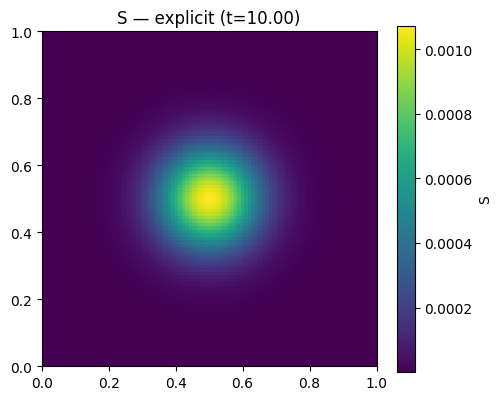

[Zapisano wykres] figs/explicit_S_final.png


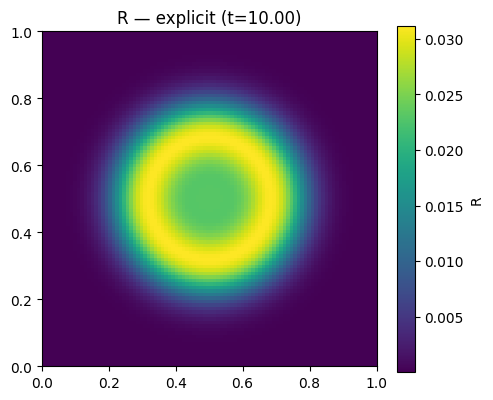

[Zapisano wykres] figs/explicit_R_final.png


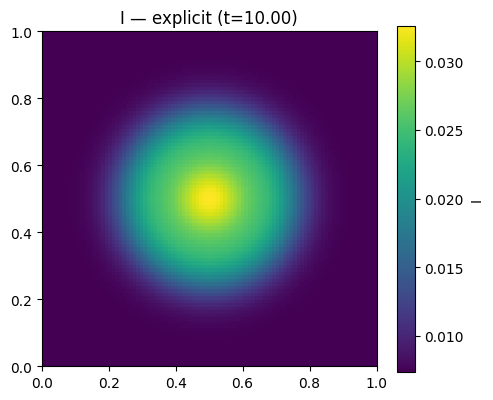

[Zapisano wykres] figs/explicit_I_final.png


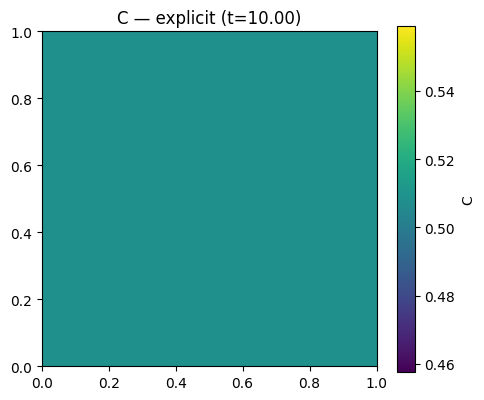

[Zapisano wykres] figs/explicit_C_final.png
[Zapisano trajektorię] out/semi_implicit_Nx96_Ny96_traj.csv
[Zapisano metadane] out/semi_implicit_Nx96_Ny96_info.json
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_S_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_R_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_I_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_C_final.npy


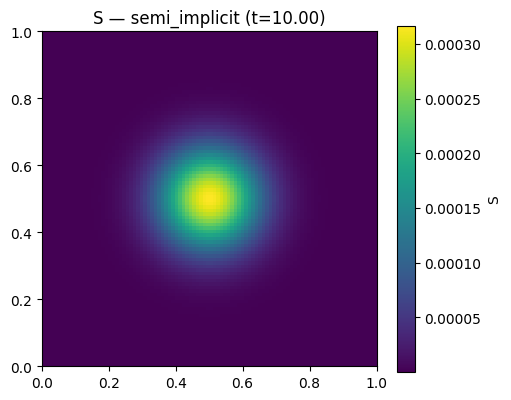

[Zapisano wykres] figs/semi_implicit_S_final.png


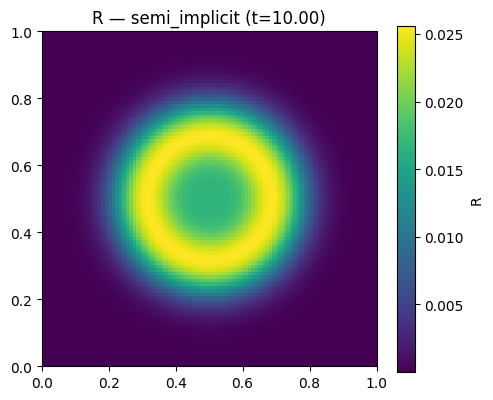

[Zapisano wykres] figs/semi_implicit_R_final.png


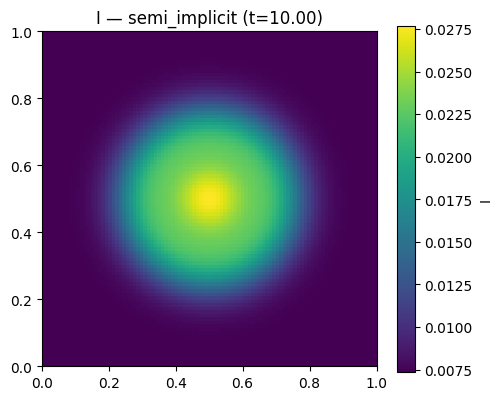

[Zapisano wykres] figs/semi_implicit_I_final.png


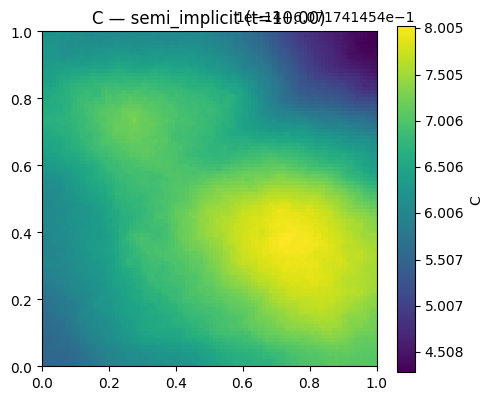

[Zapisano wykres] figs/semi_implicit_C_final.png
[Zapisano wykres] figs/compare_tb.png


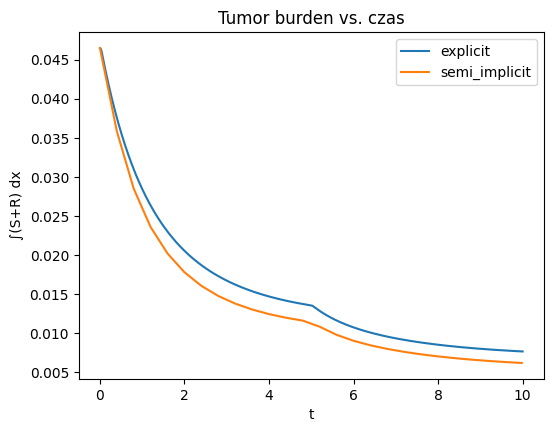

In [27]:
# Siatka średniej wielkości
grid = Grid(Nx=96, Ny=96, Lx=1.0, Ly=1.0)

# Parametry bazowe
p = Params(
    D_S=0.0, D_R=0.0, D_I=0.0, D_C=1.5e-2,
    rho_S=0.04, rho_R=0.03, K=1.0,
    alpha_S=0.8, alpha_R=0.12,
    gamma_S=0.02, gamma_R=0.02,
    sigma=0.05, delta=0.1,
    lam=0.2, beta=0.0,
    mu_max=0.05, C50=0.2, m_hill=3,
    dose_type="bolus_periodic", dose_A=1.0, dose_period=5.0
)

# Uruchom dwa solwery (jeśli SciPy dostępne)
solvers = ["explicit"] + (["semi_implicit"] if SCIPY_AVAILABLE else [])

results = {}
for solver in solvers:
    (S, R, I, C), traj, info = run_simulation(
        solver_name=solver, grid=grid, p=p,
        T=10.0, dt=None, save_every=20, theta=1.0
    )
    results[solver] = {"S":S, "R":R, "I":I, "C":C, "traj":traj, "info":info}

    # Zapisy
    base = f"out/{solver}_Nx{grid.Nx}_Ny{grid.Ny}"
    save_traj_csv(base + "_traj.csv", traj)
    save_info_json(base + "_info.json", info)
    save_array(base + "_S_final", S)
    save_array(base + "_R_final", R)
    save_array(base + "_I_final", I)
    save_array(base + "_C_final", C)

    # Wykresy 2D pól końcowych
    for name, U in [("S",S), ("R",R), ("I",I), ("C",C)]:
        plt.figure(figsize=(5.4,4.5))
        plt.imshow(U.T, origin="lower", extent=[0,grid.Lx,0,grid.Ly], aspect="equal")
        plt.colorbar(label=name)
        plt.title(f"{name} — {solver} (t={info['T']:.2f})")
        plt.show()
        savefig(f"figs/{solver}_{name}_final.png")
        plt.close()

# Porównanie trajektorii TB
plt.figure(figsize=(6.0,4.5))
for solver in solvers:
    t = [r["t"] for r in results[solver]["traj"]]
    tb = [r["tumor_burden"] for r in results[solver]["traj"]]
    plt.plot(t, tb, label=solver)
plt.xlabel("t")
plt.ylabel("∫(S+R) dx")
plt.title("Tumor burden vs. czas")
plt.legend()
savefig("figs/compare_tb.png")
plt.show()

### Importy i konfiguracja środowiska

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

[explicit] N=64  dt=9.070e-04  time=0.74s  TB=0.01344
[semi_implicit] N=64  dt=2.000e-02  time=1.22s  TB=0.01149
[explicit] N=96  dt=3.989e-04  time=3.47s  TB=0.01357
[semi_implicit] N=96  dt=2.000e-02  time=3.20s  TB=0.01149
[explicit] N=128  dt=2.232e-04  time=8.83s  TB=0.01358
[semi_implicit] N=128  dt=2.000e-02  time=6.71s  TB=0.01149
[Zapisano] out/benchmark_resolutions.csv
[Zapisano wykres] figs/benchmark_time_vs_N.png


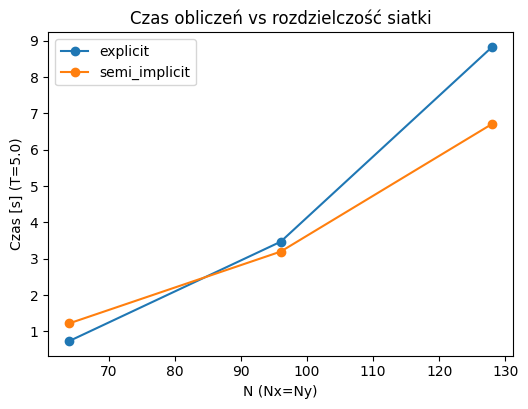

In [28]:
import csv
import matplotlib.pyplot as plt

def benchmark_resolutions(solvers, base_params: Params, sizes=(64, 96, 128), T=5.0):
    rows = []
    for N in sizes:
        grid = Grid(Nx=N, Ny=N, Lx=1.0, Ly=1.0)
        for solver in solvers:
            # dt=None -> explicit użyje stability_dt_explicit, semi_implicit użyje domyślnego (np. 0.02)
            (S, R, I, C), traj, info = run_simulation(
                solver_name=solver, grid=grid, p=base_params, T=T, dt=None, save_every=999, theta=0.5
            )
            rows.append({
                "solver": solver,
                "Nx": N, "Ny": N,
                "dt": info["dt"], "steps": info["steps"],
                "time_sec": info["time_sec"],
                "TB_final": float(((S+R).sum())*grid.dx*grid.dy)
            })
            print(f"[{solver}] N={N}  dt={info['dt']:.3e}  time={info['time_sec']:.2f}s  TB={rows[-1]['TB_final']:.5f}")
    return rows

# jakie solvery porównujemy
solvers = ["explicit"] + (["semi_implicit"] if SCIPY_AVAILABLE else [])
bench = benchmark_resolutions(solvers, p, sizes=(64, 96, 128), T=5.0)

# zapis wyników
with open("out/benchmark_resolutions.csv", "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(bench[0].keys()))
    w.writeheader()
    w.writerows(bench)
print("[Zapisano] out/benchmark_resolutions.csv")

# wykres czasu vs N
plt.figure(figsize=(6.0,4.2))
for solver in solvers:
    xs = [r["Nx"] for r in bench if r["solver"] == solver]
    ts = [r["time_sec"] for r in bench if r["solver"] == solver]
    plt.plot(xs, ts, marker="o", label=solver)
plt.xlabel("N (Nx=Ny)")
plt.ylabel("Czas [s] (T=5.0)")
plt.title("Czas obliczeń vs rozdzielczość siatki")
plt.legend()
savefig("figs/benchmark_time_vs_N.png")
plt.show()


### Główna pętla symulacji i zapisy wyników

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

[explicit] dt=1.008e-03 steps=4962 time=0.68s
[explicit] dt=6.719e-04 steps=7442 time=1.00s
[explicit] dt=5.039e-04 steps=9923 time=1.31s
[explicit] dt=3.359e-04 steps=14884 time=1.97s
[Zapisano wykres] figs/stability_vs_dt_explicit.png


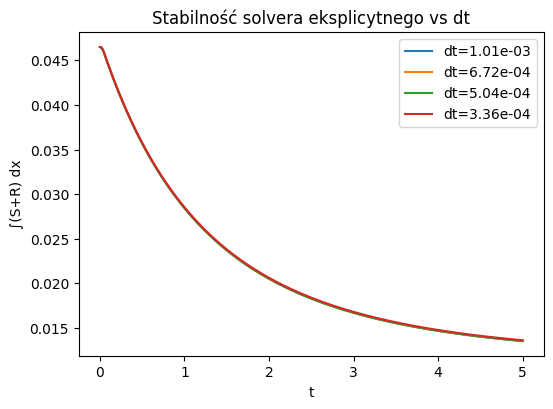

In [29]:
# badamy solver eksplicytny dla różnych dt na stałej siatce
grid_stab = Grid(Nx=64, Ny=64, Lx=1.0, Ly=1.0)
base_dt = stability_dt_explicit(grid_stab, p, safety=0.24)
dts = [base_dt, 2*base_dt/3, base_dt/2, base_dt/3]  # kilka bezpiecznych wariantów

curves = []
for dt in dts:
    (S, R, I, C), traj, info = run_simulation(
        solver_name="explicit", grid=grid_stab, p=p, T=5.0, dt=dt, save_every=10
    )
    t = [row["t"] for row in traj]
    tb = [row["tumor_burden"] for row in traj]
    curves.append((dt, t, tb))
    print(f"[explicit] dt={info['dt']:.3e} steps={info['steps']} time={info['time_sec']:.2f}s")

plt.figure(figsize=(6.0,4.2))
for dt, t, tb in curves:
    plt.plot(t, tb, label=f"dt={dt:.2e}")
plt.xlabel("t")
plt.ylabel("∫(S+R) dx")
plt.title("Stabilność solvera eksplicytnego vs dt")
plt.legend()
savefig("figs/stability_vs_dt_explicit.png")
plt.show()


### Importy i konfiguracja środowiska

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

D_C=0.005 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.01 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.02 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.03 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
alpha_S=0.4 -> TB_final=0.01855 (solver=semi_implicit, dt=2.000e-02)
alpha_S=0.8 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
alpha_S=1 -> TB_final=0.01027 (solver=semi_implicit, dt=2.000e-02)
alpha_S=1.2 -> TB_final=0.00962 (solver=semi_implicit, dt=2.000e-02)
mu_max=0 -> TB_final=0.01016 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.02 -> TB_final=0.01071 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.05 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.1 -> TB_final=0.01268 (solver=semi_implicit, dt=2.000e-02)
[Zapisano] out/param_sweep_basic.csv
[Zapisano wykres] figs/param_Dc_tb.png


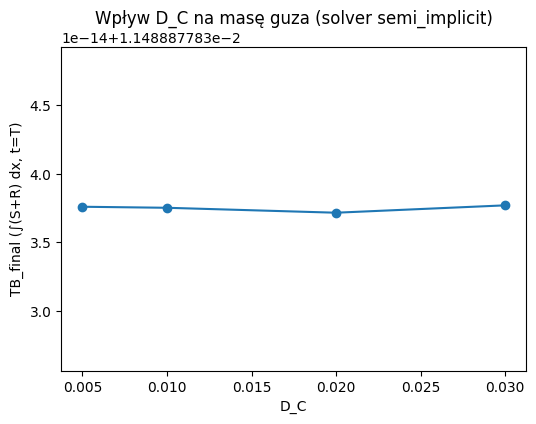

[Zapisano wykres] figs/param_alphaS_tb.png


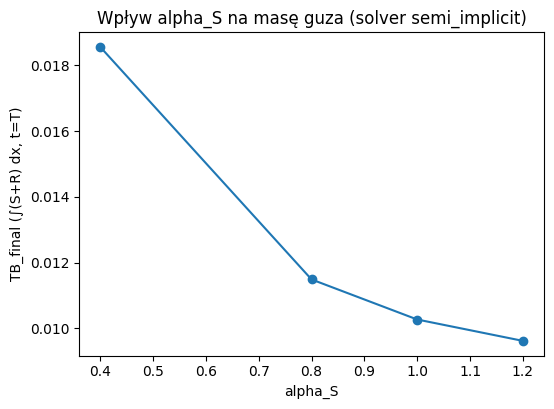

[Zapisano wykres] figs/param_mu_tb.png


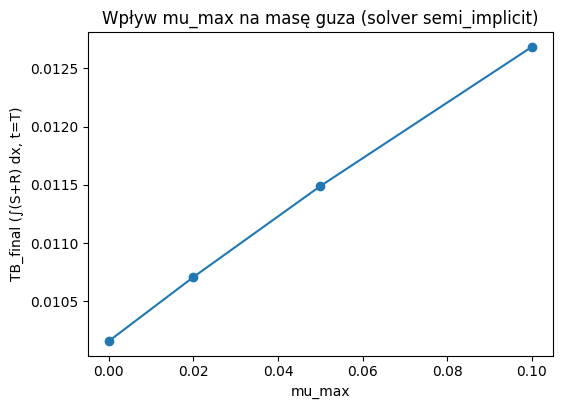

In [30]:
def param_sweep_1d(param_name, values, solver="semi_implicit", N=64, T=5.0):
    grid = Grid(Nx=N, Ny=N, Lx=1.0, Ly=1.0)
    rows = []
    for val in values:
        p_test = Params(**asdict(p))
        setattr(p_test, param_name, val)
        (S, R, I, C), traj, info = run_simulation(
            solver_name=solver, grid=grid, p=p_test, T=T, dt=None, save_every=999, theta=0.5
        )
        TB_final = float(((S+R).sum()) * grid.dx * grid.dy)
        rows.append({"param": param_name, "value": val, "TB_final": TB_final,
                     "solver": solver, "dt": info["dt"], "time_sec": info["time_sec"]})
        print(f"{param_name}={val:.4g} -> TB_final={TB_final:.5f} (solver={solver}, dt={info['dt']:.3e})")
    return rows

# zakresy do demonstracji (możesz zmienić szerokość)
vals_Dc = [5e-3, 1.0e-2, 2.0e-2, 3.0e-2]
vals_alphaS = [0.4, 0.8, 1.0, 1.2]
vals_mu = [0.0, 0.02, 0.05, 0.1]

rows = []
rows += param_sweep_1d("D_C", vals_Dc, solver="semi_implicit", N=64, T=5.0)
rows += param_sweep_1d("alpha_S", vals_alphaS, solver="semi_implicit", N=64, T=5.0)
rows += param_sweep_1d("mu_max", vals_mu, solver="semi_implicit", N=64, T=5.0)

# zapis CSV
with open("out/param_sweep_basic.csv", "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader()
    w.writerows(rows)
print("[Zapisano] out/param_sweep_basic.csv")

# wykresy TB_final vs wartość parametru
def plot_param_curve(rows, pname, out_png):
    sub = [r for r in rows if r["param"]==pname]
    xs = [r["value"] for r in sub]
    ys = [r["TB_final"] for r in sub]
    plt.figure(figsize=(6.0,4.2))
    plt.plot(xs, ys, marker="o")
    plt.xlabel(pname)
    plt.ylabel("TB_final (∫(S+R) dx, t=T)")
    plt.title(f"Wpływ {pname} na masę guza (solver semi_implicit)")
    savefig(out_png)
    plt.show()

plot_param_curve(rows, "D_C", "figs/param_Dc_tb.png")
plot_param_curve(rows, "alpha_S", "figs/param_alphaS_tb.png")
plot_param_curve(rows, "mu_max", "figs/param_mu_tb.png")

### Główna pętla symulacji i zapisy wyników

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

[Zapisano trajektorię] out/compare_explicit_N96_traj.csv
[Zapisano metadane] out/compare_explicit_N96_info.json
[Zapisano macierz] out/compare_explicit_N96_S_final.npy
[Zapisano macierz] out/compare_explicit_N96_R_final.npy
[Zapisano macierz] out/compare_explicit_N96_I_final.npy
[Zapisano macierz] out/compare_explicit_N96_C_final.npy
[Tworzenie GIF dla explicit...]
  Liczba klatek: 39, dt=0.000399, save_every=400
[Zapisano animację] figs/compare_explicit_animation.gif
[Zapisano wykres] figs/compare_explicit_all_fields_final.png


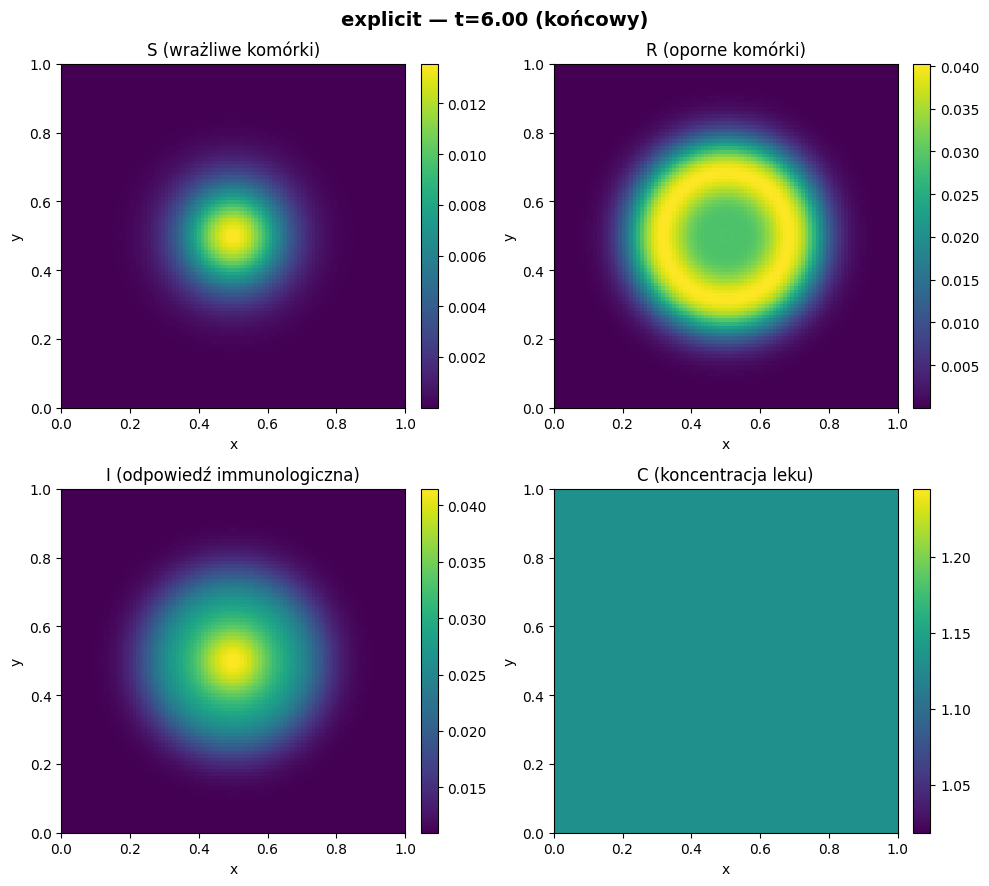

[Zapisano trajektorię] out/compare_semi_implicit_N96_traj.csv
[Zapisano metadane] out/compare_semi_implicit_N96_info.json
[Zapisano macierz] out/compare_semi_implicit_N96_S_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_R_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_I_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_C_final.npy
[Tworzenie GIF dla semi_implicit...]
  Liczba klatek: 16, dt=0.020000, save_every=20
[Zapisano animację] figs/compare_semi_implicit_animation.gif
[Zapisano wykres] figs/compare_semi_implicit_all_fields_final.png


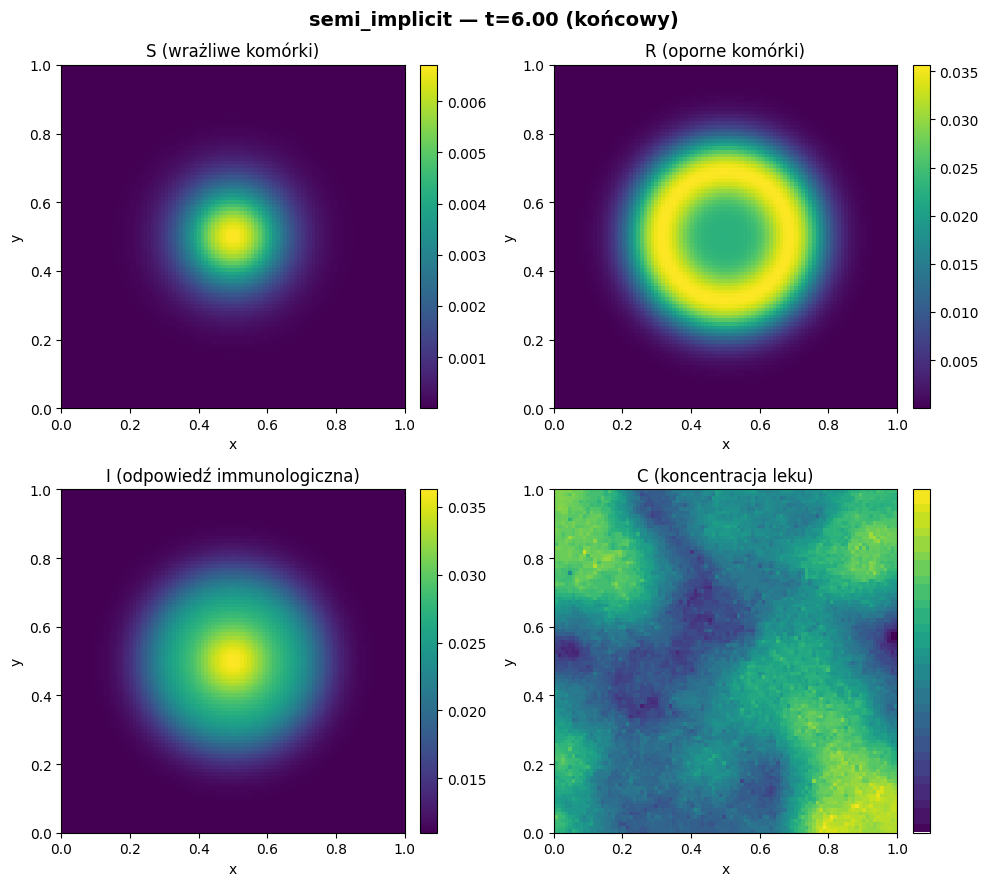

[Zapisano wykres] figs/compare_solvers_tb.png


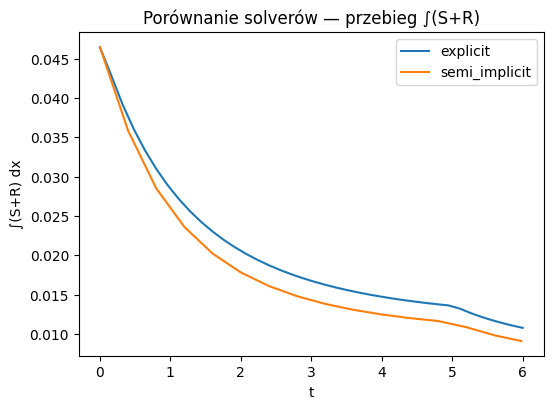

In [31]:
# stała siatka i parametry; identyczny T i save_every
grid_cmp = Grid(Nx=96, Ny=96, Lx=1.0, Ly=1.0)

def compare_solvers_once(grid, p, T=6.0):
    out = {}
    for solver in ["explicit"] + (["semi_implicit"] if SCIPY_AVAILABLE else []):
        # Dla explicit używamy większej wartości save_every, żeby mieć podobne odstępy czasowe jak semi_implicit
        if solver == "explicit":
            # Explicit ma mniejsze dt (~0.001), więc potrzebujemy większego save_every
            save_every_val = 400  # Dostosuj tę wartość, aby uzyskać ~0.4s między klatkami
        else:
            # Semi_implicit ma dt~0.02, więc save_every=20 daje ~0.4s
            save_every_val = 20
            
        result = run_simulation(
            solver_name=solver, grid=grid, p=p, T=T, dt=None, save_every=save_every_val, theta=0.5, save_snapshots=True
        )
        (S, R, I, C), traj, info, snapshots = result
        out[solver] = {"S":S, "R":R, "I":I, "C":C, "traj":traj, "info":info, "snapshots":snapshots}
        base = f"out/compare_{solver}_N{grid.Nx}"
        save_traj_csv(base + "_traj.csv", traj)
        save_info_json(base + "_info.json", info)
        save_array(base + "_S_final", S)
        save_array(base + "_R_final", R)
        save_array(base + "_I_final", I)
        save_array(base + "_C_final", C)

        # Tworzenie GIF z animacją wszystkich pól w układzie 2x2
        print(f"[Tworzenie GIF dla {solver}...]")
        print(f"  Liczba klatek: {len(snapshots)}, dt={info['dt']:.6f}, save_every={save_every_val}")
        try:
            from PIL import Image
            PIL_AVAILABLE = True
        except:
            PIL_AVAILABLE = False
            print("  Uwaga: Pillow niedostępny — GIF nie zostanie utworzony")

        if PIL_AVAILABLE:
            frames = []
            # Określenie zakresów kolorów dla spójności między klatkami
            vmin_S, vmax_S = 0, max([s["S"].max() for s in snapshots])
            vmin_R, vmax_R = 0, max([s["R"].max() for s in snapshots])
            vmin_I, vmax_I = 0, max([s["I"].max() for s in snapshots])
            vmin_C, vmax_C = 0, max([s["C"].max() for s in snapshots])
            
            for snap in snapshots:
                fig, axes = plt.subplots(2, 2, figsize=(10, 9))
                fig.suptitle(f"{solver} — t={snap['t']:.2f}", fontsize=14, fontweight='bold')

                # S (górny lewy)
                im0 = axes[0,0].imshow(snap["S"].T, origin="lower", extent=[0,grid.Lx,0,grid.Ly],
                                       aspect="equal", vmin=vmin_S, vmax=vmax_S, cmap='viridis')
                axes[0,0].set_title("S (wrażliwe komórki)")
                axes[0,0].set_xlabel("x")
                axes[0,0].set_ylabel("y")
                plt.colorbar(im0, ax=axes[0,0], fraction=0.046, pad=0.04)

                # R (górny prawy)
                im1 = axes[0,1].imshow(snap["R"].T, origin="lower", extent=[0,grid.Lx,0,grid.Ly],
                                       aspect="equal", vmin=vmin_R, vmax=vmax_R, cmap='viridis')
                axes[0,1].set_title("R (oporne komórki)")
                axes[0,1].set_xlabel("x")
                axes[0,1].set_ylabel("y")
                plt.colorbar(im1, ax=axes[0,1], fraction=0.046, pad=0.04)

                # I (dolny lewy)
                im2 = axes[1,0].imshow(snap["I"].T, origin="lower", extent=[0,grid.Lx,0,grid.Ly],
                                       aspect="equal", vmin=vmin_I, vmax=vmax_I, cmap='viridis')
                axes[1,0].set_title("I (odpowiedź immunologiczna)")
                axes[1,0].set_xlabel("x")
                axes[1,0].set_ylabel("y")
                plt.colorbar(im2, ax=axes[1,0], fraction=0.046, pad=0.04)

                # C (dolny prawy)
                im3 = axes[1,1].imshow(snap["C"].T, origin="lower", extent=[0,grid.Lx,0,grid.Ly],
                                       aspect="equal", vmin=vmin_C, vmax=vmax_C, cmap='viridis')
                axes[1,1].set_title("C (koncentracja leku)")
                axes[1,1].set_xlabel("x")
                axes[1,1].set_ylabel("y")
                plt.colorbar(im3, ax=axes[1,1], fraction=0.046, pad=0.04)

                plt.tight_layout()

                # Zapisz klatkę do bufora (używamy buffer_rgba() zamiast tostring_rgb())
                fig.canvas.draw()
                # Konwersja bufora RGBA do RGB
                buf = fig.canvas.buffer_rgba()
                img = Image.frombuffer('RGBA', fig.canvas.get_width_height(), buf, 'raw', 'RGBA', 0, 1)
                img = img.convert('RGB')
                frames.append(img)
                plt.close(fig)

            # Zapisz GIF
            gif_path = f"figs/compare_{solver}_animation.gif"
            frames[0].save(gif_path, save_all=True, append_images=frames[1:],
                          duration=200, loop=0)
            print(f"[Zapisano animację] {gif_path}")

        # Zapisz także końcowy obraz 2x2 jako statyczny PNG
        fig, axes = plt.subplots(2, 2, figsize=(10, 9))
        fig.suptitle(f"{solver} — t={info['T']:.2f} (końcowy)", fontsize=14, fontweight='bold')

        im0 = axes[0,0].imshow(S.T, origin="lower", extent=[0,grid.Lx,0,grid.Ly], aspect="equal", cmap='viridis')
        axes[0,0].set_title("S (wrażliwe komórki)")
        axes[0,0].set_xlabel("x")
        axes[0,0].set_ylabel("y")
        plt.colorbar(im0, ax=axes[0,0], fraction=0.046, pad=0.04)

        im1 = axes[0,1].imshow(R.T, origin="lower", extent=[0,grid.Lx,0,grid.Ly], aspect="equal", cmap='viridis')
        axes[0,1].set_title("R (oporne komórki)")
        axes[0,1].set_xlabel("x")
        axes[0,1].set_ylabel("y")
        plt.colorbar(im1, ax=axes[0,1], fraction=0.046, pad=0.04)

        im2 = axes[1,0].imshow(I.T, origin="lower", extent=[0,grid.Lx,0,grid.Ly], aspect="equal", cmap='viridis')
        axes[1,0].set_title("I (odpowiedź immunologiczna)")
        axes[1,0].set_xlabel("x")
        axes[1,0].set_ylabel("y")
        plt.colorbar(im2, ax=axes[1,0], fraction=0.046, pad=0.04)

        im3 = axes[1,1].imshow(C.T, origin="lower", extent=[0,grid.Lx,0,grid.Ly], aspect="equal", cmap='viridis')
        axes[1,1].set_title("C (koncentracja leku)")
        axes[1,1].set_xlabel("x")
        axes[1,1].set_ylabel("y")
        plt.colorbar(im3, ax=axes[1,1], fraction=0.046, pad=0.04)

        plt.tight_layout()
        savefig(f"figs/compare_{solver}_all_fields_final.png")
        plt.show()
        plt.close()

    return out

comparison = compare_solvers_once(grid_cmp, p, T=6.0)

# wspólny wykres TB
plt.figure(figsize=(6.0,4.2))
for solver, pack in comparison.items():
    t = [r["t"] for r in pack["traj"]]
    tb = [r["tumor_burden"] for r in pack["traj"]]
    plt.plot(t, tb, label=solver)
plt.xlabel("t")
plt.ylabel("∫(S+R) dx")
plt.title("Porównanie solverów — przebieg ∫(S+R)")
plt.legend()
savefig("figs/compare_solvers_tb.png")
plt.show()

### Główna pętla symulacji i zapisy wyników

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

Relatywna różnica krzywych TB (norma 2): 1.346e-14
[Zapisano] out/compare_solvers_same_dt.csv
[Zapisano wykres] figs/compare_solvers_same_dt.png


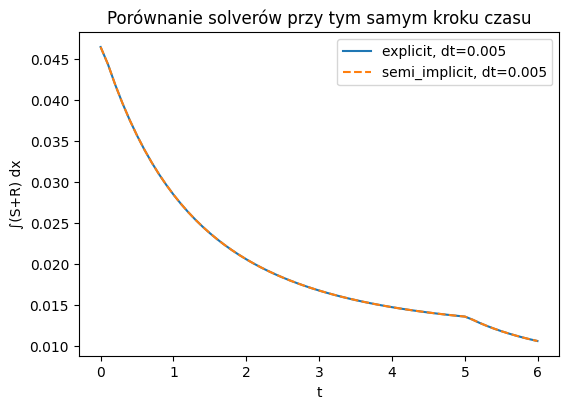

[Zapisano wykres] figs/compare_solvers_same_dt_diff.png


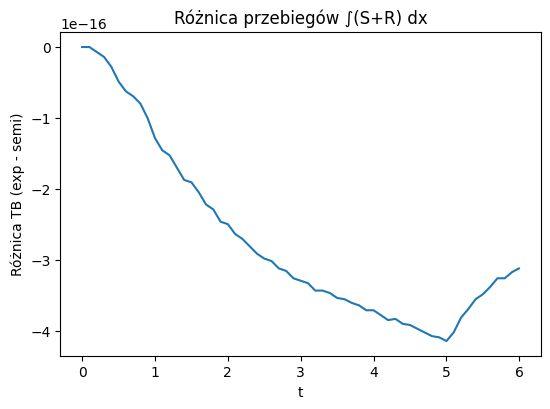

In [32]:
grid_cmp = Grid(Nx=96, Ny=96, Lx=1.0, Ly=1.0)
p_cmp = Params(**asdict(p))

T = 6.0
dt_same = 5e-3  # wspólny krok dla obu solverów (stabilny dla semi_implicit, akceptowalny dla explicit)
(S1, R1, I1, C1), traj1, info1 = run_simulation("explicit", grid_cmp, p_cmp, T=T, dt=dt_same, save_every=20, theta=0.5)
(S2, R2, I2, C2), traj2, info2 = run_simulation("semi_implicit", grid_cmp, p_cmp, T=T, dt=dt_same, save_every=20, theta=0.5)

t1 = np.array([r["t"] for r in traj1])
tb1 = np.array([r["tumor_burden"] for r in traj1])
t2 = np.array([r["t"] for r in traj2])
tb2 = np.array([r["tumor_burden"] for r in traj2])

# interpolacja jednego do siatki czasowej drugiego (na wszelki wypadek)
if len(t1) != len(t2) or not np.allclose(t1, t2):
    from numpy import interp
    tb2i = interp(t1, t2, tb2)
    T_common, TB_exp, TB_semi = t1, tb1, tb2i
else:
    T_common, TB_exp, TB_semi = t1, tb1, tb2

rel_err = np.linalg.norm(TB_exp - TB_semi) / max(np.linalg.norm(TB_exp), 1e-12)
print(f"Relatywna różnica krzywych TB (norma 2): {rel_err:.3e}")

with open("out/compare_solvers_same_dt.csv", "w", newline="") as f:
    w = csv.writer(f); w.writerow(["t","TB_explicit","TB_semi_implicit"])
    for t, a, b in zip(T_common, TB_exp, TB_semi):
        w.writerow([t, a, b])
print("[Zapisano] out/compare_solvers_same_dt.csv")

plt.figure(figsize=(6.2,4.2))
plt.plot(T_common, TB_exp, label="explicit, dt=%.3g" % dt_same)
plt.plot(T_common, TB_semi, "--", label="semi_implicit, dt=%.3g" % dt_same)
plt.xlabel("t"); plt.ylabel("∫(S+R) dx")
plt.title("Porównanie solverów przy tym samym kroku czasu")
plt.legend()
savefig("figs/compare_solvers_same_dt.png")
plt.show()

plt.figure(figsize=(6.2,4.2))
plt.plot(T_common, TB_exp - TB_semi)
plt.xlabel("t"); plt.ylabel("Różnica TB (exp - semi)")
plt.title("Różnica przebiegów ∫(S+R) dx")
savefig("figs/compare_solvers_same_dt_diff.png")
plt.show()

### Funkcja apply_boundary_C (warunki brzegowe C)

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane późnie

In [33]:
def apply_boundary_C(C, grid: Grid, bc_type="neumann", value=0.0, robin_alpha=0.0, robin_value=0.0):
    """
    Proste narzucenie warunków brzegowych dla pola C po kroku czasowym.

    bc_type:
      - 'neumann'  : nic nie zmieniamy (pochodna normalna ~ 0 jest już w operatorze).
      - 'dirichlet': ustawiamy C = value na brzegu.
      - 'robin'    : dC/dn + alpha*(C - robin_value) = 0
                     Przybliżenie: relaksacja brzegu C_b := (C_b + alpha*h*robin_value)/(1 + alpha*h),
                     gdzie h ~ średnia z dx, dy.
    """
    if bc_type == "neumann":
        return C

    if bc_type == "dirichlet":
        C[0,  :] = value
        C[-1, :] = value
        C[:,  0] = value
        C[:, -1] = value
        return C

    if bc_type == "robin":
        h = 0.5 * (grid.dx + grid.dy)
        factor = robin_alpha * h
        if factor > 0.0:
            # góra / dół
            C[0,  :] = (C[0,  :] + factor * robin_value) / (1.0 + factor)
            C[-1, :] = (C[-1, :] + factor * robin_value) / (1.0 + factor)
            # lewa / prawa
            C[:,  0] = (C[:,  0] + factor * robin_value) / (1.0 + factor)
            C[:, -1] = (C[:, -1] + factor * robin_value) / (1.0 + factor)
        return C

    return C

### Krok solvera eksplicytnego (jawnego)

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

D_C=0.005 -> TB_final=0.02611
D_C=0.01 -> TB_final=0.02625
D_C=0.02 -> TB_final=0.02656
D_C=0.03 -> TB_final=0.02680
D_C=0.05 -> TB_final=0.02711
[Zapisano] out/robin_beta_sweep_Dc.csv
[Zapisano wykres] figs/robin_beta_Dc_influence.png


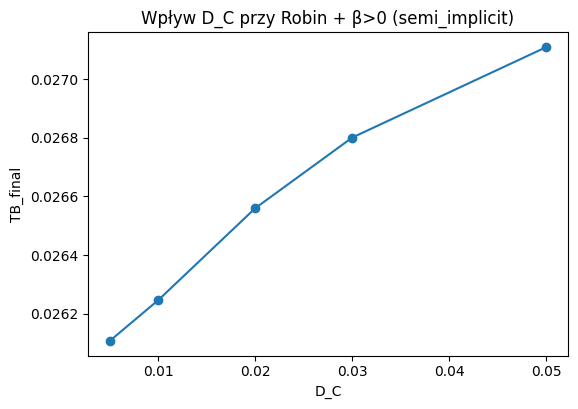

In [34]:
def run_with_robin_and_beta(grid, p_base: Params, T=5.0, dt=None, theta=0.5,
                            bc_alpha=5.0, bc_value=0.0, beta_val=0.1,
                            solver="semi_implicit", save_every=999):
    p_loc = Params(**asdict(p_base))
    p_loc.beta = beta_val
    if dt is None:
        dt = 0.02 if solver=="semi_implicit" else stability_dt_explicit(grid, p_loc)
    (S, R, I, C) = init_fields(grid)
    sys_mats = {}
    if solver=="semi_implicit" and SCIPY_AVAILABLE:
        sys_mats = build_sys_mats(grid, p_loc, dt, theta=theta)
    steps = int(np.ceil(T/dt))
    tb_traj = []
    for n in range(steps):
        t = n*dt
        if solver=="explicit":
            step_explicit.t = t
            S, R, I, C = step_explicit(S, R, I, C, grid, dt, p_loc)
        else:
            step_semi_implicit.t = t
            S, R, I, C = step_semi_implicit(S, R, I, C, grid, dt, p_loc, sys_mats, theta=theta)
        # Robin na brzegu dla C po kroku
        C = apply_boundary_C(C, grid, bc_type="robin", robin_alpha=bc_alpha, robin_value=bc_value)
        if (n % save_every)==0 or n==steps-1:
            tb_traj.append(((S+R).sum()*grid.dx*grid.dy))
    TB_final = float((S+R).sum()*grid.dx*grid.dy)
    return TB_final, S, R, I, C, tb_traj, {"dt":dt,"steps":steps}

grid_robin = Grid(Nx=96, Ny=96, Lx=1.0, Ly=1.0)
p_robin = Params(**asdict(p))
p_robin.dose_type = "infusion_const"  # żeby efekt Robin był wyraźny bez impulsów
p_robin.infusion_rate = 0.15

Dc_vals = [5e-3, 1e-2, 2e-2, 3e-2, 5e-2]
rows = []
for Dc in Dc_vals:
    p_robin.D_C = Dc
    TBf, S,R,I,C, tbtraj, info = run_with_robin_and_beta(
        grid_robin, p_robin, T=5.0, dt=0.02, theta=0.5,
        bc_alpha=5.0, bc_value=0.0, beta_val=0.1,
        solver="semi_implicit", save_every=50
    )
    rows.append({"D_C":Dc, "TB_final":TBf, "dt":info["dt"], "steps":info["steps"]})
    print(f"D_C={Dc:.3g} -> TB_final={TBf:.5f}")

with open("out/robin_beta_sweep_Dc.csv","w",newline="") as f:
    w = csv.DictWriter(f, fieldnames=rows[0].keys()); w.writeheader(); w.writerows(rows)
print("[Zapisano] out/robin_beta_sweep_Dc.csv")

plt.figure(figsize=(6.2,4.2))
plt.plot([r["D_C"] for r in rows], [r["TB_final"] for r in rows], marker="o")
plt.xlabel("D_C"); plt.ylabel("TB_final")
plt.title("Wpływ D_C przy Robin + β>0 (semi_implicit)")
savefig("figs/robin_beta_Dc_influence.png")
plt.show()


### Główna pętla symulacji i zapisy wyników

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

alpha_S=0.4 [LO] -> TB_final=0.01401, time=1.47s
alpha_S=1.2 [HI] -> TB_final=0.00809, time=1.49s
mu_max=0.0 [LO] -> TB_final=0.00768, time=1.48s
mu_max=0.1 [HI] -> TB_final=0.01031, time=1.47s
lam=0.05 [LO] -> TB_final=0.00663, time=1.48s
lam=0.5 [HI] -> TB_final=0.01391, time=1.47s
sigma=0.0 [LO] -> TB_final=0.00910, time=1.48s
sigma=0.1 [HI] -> TB_final=0.00908, time=1.48s
[Zapisano] out/extremes_summary.csv
[Zapisano wykres] figs/extremes_tb_bar.png


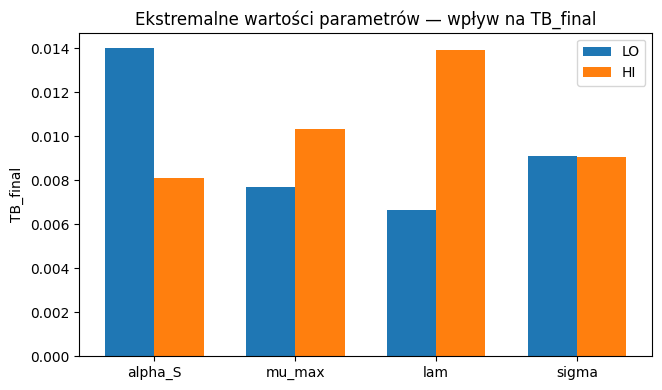

In [35]:
extreme_sets = {
    "alpha_S": [0.4, 1.2],
    "mu_max": [0.0, 0.1],
    "lam": [0.05, 0.5],
    "sigma": [0.0, 0.1]
}

grid_ext = Grid(Nx=64, Ny=64, Lx=1.0, Ly=1.0)
rows_ext = []
for pname, vals in extreme_sets.items():
    for tag, val in zip(["LO","HI"], vals):
        p_ext = Params(**asdict(p))
        setattr(p_ext, pname, val)
        (S, R, I, C), traj, info = run_simulation("semi_implicit", grid_ext, p_ext, T=6.0, dt=None, save_every=999, theta=0.5)
        TBf = float(((S+R).sum())*grid_ext.dx*grid_ext.dy)
        rows_ext.append({"param":pname,"tag":tag,"value":val,"TB_final":TBf,"time_sec":info["time_sec"]})
        print(f"{pname}={val} [{tag}] -> TB_final={TBf:.5f}, time={info['time_sec']:.2f}s")

with open("out/extremes_summary.csv","w",newline="") as f:
    w = csv.DictWriter(f, fieldnames=rows_ext[0].keys()); w.writeheader(); w.writerows(rows_ext)
print("[Zapisano] out/extremes_summary.csv")

# wykres słupkowy: wpływ LO/HI
plt.figure(figsize=(7.4,4.2))
params_order = list(extreme_sets.keys())
x = np.arange(len(params_order))
width = 0.35
tb_lo = []; tb_hi = []
for pname in params_order:
    lo = [r["TB_final"] for r in rows_ext if r["param"]==pname and r["tag"]=="LO"][0]
    hi = [r["TB_final"] for r in rows_ext if r["param"]==pname and r["tag"]=="HI"][0]
    tb_lo.append(lo); tb_hi.append(hi)
plt.bar(x-width/2, tb_lo, width, label="LO")
plt.bar(x+width/2, tb_hi, width, label="HI")
plt.xticks(x, params_order, rotation=0)
plt.ylabel("TB_final")
plt.title("Ekstremalne wartości parametrów — wpływ na TB_final")
plt.legend()
savefig("figs/extremes_tb_bar.png")
plt.show()


### Główna pętla symulacji i zapisy wyników

- Cel: krótki opis roli tej komórki.
- Wyjścia: ewentualne pliki (CSV/PNG) i zmienne wykorzystywane później.

[Zapisano wykres] figs/panel_maps_explicit.png
[Zapisano wykres] figs/panel_maps_semi_implicit.png
[Zapisano wykres] figs/panel_tb_compare.png


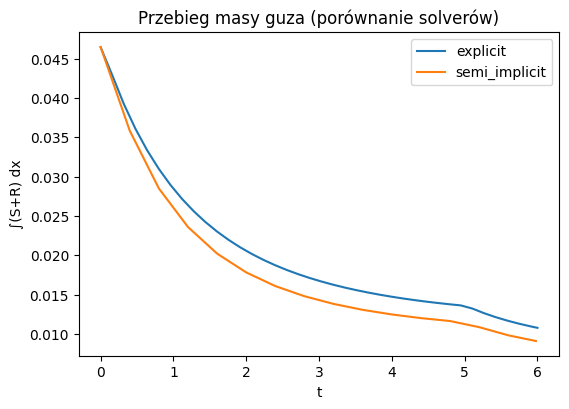

In [36]:
def save_maps_panel(S, R, I, C, grid, title, out_png):
    fig, axes = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
    for ax, U, name in zip(axes.ravel(), [S,R,I,C], ["S","R","I","C"]):
        im = ax.imshow(U.T, origin="lower", extent=[0,grid.Lx,0,grid.Ly], aspect="equal")
        ax.set_title(name)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle(title)
    savefig(out_png)
    plt.close(fig)

# z porównania z komórki 14 masz 'comparison'; jeśli nie, utwórz szybko:
try:
    _ = comparison
except NameError:
    grid_cmp2 = Grid(Nx=96, Ny=96, Lx=1.0, Ly=1.0)
    comparison = {}
    for solver in ["explicit"] + (["semi_implicit"] if SCIPY_AVAILABLE else []):
        (S, R, I, C), traj, info = run_simulation(solver, grid_cmp2, p, T=6.0, dt=None, save_every=20, theta=0.5)
        comparison[solver] = {"S":S,"R":R,"I":I,"C":C,"traj":traj,"info":info,"grid":grid_cmp2}

for solver, pack in comparison.items():
    save_maps_panel(pack["S"], pack["R"], pack["I"], pack["C"], grid_cmp, 
                    f"Mapy pól — {solver} (t={pack['info']['T']:.1f})",
                    f"figs/panel_maps_{solver}.png")

# wspólny wykres TB z legendą i opisem
plt.figure(figsize=(6.2,4.2))
for solver, pack in comparison.items():
    t = [r["t"] for r in pack["traj"]]
    tb = [r["tumor_burden"] for r in pack["traj"]]
    plt.plot(t, tb, label=solver)
plt.xlabel("t"); plt.ylabel("∫(S+R) dx")
plt.title("Przebieg masy guza (porównanie solverów)")
plt.legend()
savefig("figs/panel_tb_compare.png")
plt.show()
